In [1]:
import pandas as pd
import re
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from math import radians, sin, cos, asin, sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
InteractiveShell.ast_node_interactivity ='all'

pd.set_option('display.max_columns', None)    #显示所有列
pd.set_option('display.max_rows', 30)    #显示所有行
pd.set_option('max_colwidth',100)    #设置value的显示长度为100，默认为50

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier

# 集成分类库和投票方法库
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
# StratifiedKFold：适用于有标签数据集的交叉检验数据集划分方法。cross_val_score：通过交叉检验方法做模型效果评估。导入交叉检验算法
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 0. Pre_processing

In [2]:
dispatch_init = pd.read_csv('2019_all_data.csv', encoding = 'utf-8').fillna('0')
dispatch_init = dispatch_init[dispatch_init['RECEIVE_PROVINCE'] != dispatch_init['FROM_PROVINCE']]
dispatch_init.shape
dispatch_init.head(1)

(618410, 24)

,ORDER_NO,SO_NOL,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME
43,LO2019010130861655,Z121812072967,T1812314350909,合肥美的电冰箱有限公司-内销,冰箱事业部,0.932393,76.0,1.0,云南省,昆明市,官渡区,阿拉街道,普照村大麻苴马帮物流园内安得物流,湖北省,荆州市,沙市区,轻货,B,2019-01-03 08:35:31,2019-01-04 23:44:19,鄂DB5788,17.5米车,罗学忠,0.932393


### 0.1 地址统一

In [3]:
my_add = pd.read_excel('最后的地址汇总.xlsx')
your_add = pd.read_excel('res.xlsx')
my_add = my_add[['RECEIVE_CITY', 'extract_address', 'unique_address']]
final_add = pd.concat([my_add, your_add], ignore_index=True)

def replace_add(x, add_dict):
    receive_address = str(x['RECEIVE_ADDRESS'])
    values = None
    for k, v in add_dict.items():
        if k in receive_address:
            values = v
            return values
        else:
            values = receive_address
    return values

df_1= pd.DataFrame()
for name, df_group in dispatch_init.groupby("RECEIVE_CITY"):                           # 遍历分组后的城市
    add = final_add[final_add['RECEIVE_CITY'] == name]
    add_dict = dict(zip(add['extract_address'], add['unique_address']))     # 把近似地址映射成唯一地址，构建多对一词典
    df_group['FIX_ADDRESS'] = df_group.apply(lambda x: replace_add(x, add_dict), axis=1)
    df_1 = df_1.append(df_group)                                 # 将填充后的组合并到df_fix_add中
df_1 = df_1.fillna('0')
df_1['FIX_ADDRESS'] = df_1.apply(lambda x: x['RECEIVE_ADDRESS'] if x['FIX_ADDRESS'] == '0'
                                 else x['FIX_ADDRESS'] , axis = 1)
df_1.head(1)

,ORDER_NO,SO_NOL,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,FIX_ADDRESS
2116,LO2019010130888733,Z101812062980,T1901014358395,广东美的制冷设备有限公司-国内营销,家用空调事业部,60.55344,8185.5,214.0,上海市,上海市辖区,金山区,金山卫镇,金舸路188号上海金山工业园区物流园,湖北省,武汉市,蔡甸区,轻货,B,2019-01-03 19:44:08,2019-01-04 15:09:21,皖C79586,17.5米车,杨升,60.55344,金舸路188号上海金山工业园区物流园


###  0.2 卸货时间计算

In [4]:
df_2 = df_1
df_2 = df_2[df_2['ORDER_NO'] != 'LO2019051236320475']
df_2 = df_2[df_2['DO_NO']!= '0']
df_2[['PICK_UP_TIME' ,'RECEIVE_TIME']] = df_2[['PICK_UP_TIME','RECEIVE_TIME']].astype('datetime64')

df_2  = pd.merge(df_2, df_2.groupby(['DO_NO','FIX_ADDRESS']
                )['PICK_UP_TIME'].min().reset_index().rename(columns = {'PICK_UP_TIME':'PICK_UP_EARLIST'}
                ), how = 'left', on = ['DO_NO','FIX_ADDRESS']) #最早的到达时间
df_2  = pd.merge(df_2, df_2.groupby(['DO_NO','FIX_ADDRESS']
                )['RECEIVE_TIME'].max().reset_index().rename(columns = {'RECEIVE_TIME':'RECEIVE_LATEST'}
                ), how = 'left', on = ['DO_NO','FIX_ADDRESS']) #最晚的离开时间
df_2['UNLOAD_TIME'] = df_2.apply(lambda x: (x['RECEIVE_LATEST'] - x['PICK_UP_EARLIST']).total_seconds()/3600, axis = 1 )
df_2.head(1)
df_2.shape

,ORDER_NO,SO_NOL,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,FIX_ADDRESS,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,LO2019010130888733,Z101812062980,T1901014358395,广东美的制冷设备有限公司-国内营销,家用空调事业部,60.55344,8185.5,214.0,上海市,上海市辖区,金山区,金山卫镇,金舸路188号上海金山工业园区物流园,湖北省,武汉市,蔡甸区,轻货,B,2019-01-03 19:44:08,2019-01-04 15:09:21,皖C79586,17.5米车,杨升,60.55344,金舸路188号上海金山工业园区物流园,2019-01-03 19:44:08,2019-01-04 15:09:21,19.420278


(618377, 28)

### 0.3 异常数据处理

In [5]:
#对于订单体积等于入库体积的，对同一物流订单，总体积，总重量，总数量，入库体积相同，收货地不同的样本，删除统计数目大于2的样本
df_3 = df_2[df_2['VOLUME'] == df_2['RECEIVE_VOLUME']]         #入库和订单体积相同
df_3 = pd.DataFrame(df_2.groupby(['ORDER_NO', 'RECEIVE_VOLUME'])['RECEIVE_ADDRESS'].nunique()
                   ).reset_index().rename(columns = {'RECEIVE_ADDRESS': 'MARK'})
df_3 = df_3[df_3['MARK'] == 1]
df_3 = pd.merge(df_3[['ORDER_NO']], df_2, on = 'ORDER_NO', how = 'left')
# df_3 = pd.concat([df_2[df_2['VOLUME'] != df_2['RECEIVE_VOLUME']], df_3])   #入库和订单体积不同的并入
df_3.shape

(617627, 28)

In [6]:
#对于入库体积不等于订单体积的入进行数值累加
df_4 = df_2[df_2['VOLUME'] != df_2['RECEIVE_VOLUME']] 
df_4 = pd.DataFrame(df_4.groupby(['DO_NO', 'PICK_UP_EARLIST','RECEIVE_VOLUME', 'FIX_ADDRESS','CUSTOMER','BU_NAME',
    'RECEIVE_PROVINCE', 'RECEIVE_CITY', 'RECEIVE_DISTRICT','BUSINESS_TYPE','FREIGHT_BASIS', 'LICENSE', 'EQUIPMENT', 
    'DRIVER']).agg({'VOLUME':'sum', 'WEIGHT':'sum', 'QUANTITY':'sum', 'UNLOAD_TIME': 'sum'})).reset_index()
df_4 = df_4[df_4['VOLUME'] == df_4['RECEIVE_VOLUME']]

df_3 = df_3[['DO_NO', 'PICK_UP_EARLIST', 'RECEIVE_VOLUME', 'FIX_ADDRESS','CUSTOMER','BU_NAME','RECEIVE_PROVINCE', 'RECEIVE_CITY', 
        'RECEIVE_DISTRICT', 'BUSINESS_TYPE','FREIGHT_BASIS', 'LICENSE', 'EQUIPMENT','DRIVER', 'VOLUME', 'WEIGHT',
       'QUANTITY', 'UNLOAD_TIME']]
df_3 = pd.concat([df_3, df_4])
df_3.shape
df_3.head(1)

(636840, 18)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME
0,T1812314350909,2019-01-03 08:35:31,0.932393,大麻苴村马帮物流园（东方仓）,合肥美的电冰箱有限公司-内销,冰箱事业部,云南省,昆明市,官渡区,B,轻货,鄂DB5788,17.5米车,罗学忠,0.932393,76.0,1.0,39.146667


### 0.4 异常体积重量

In [7]:
df_4 = df_3
df_4['UNIT_VOLUME_WEIGHT'] = df_4['WEIGHT']/df_4['VOLUME']
def box_plot(df):
#     df = df[df['UNIT_VOLUME_WEIGHT'] != 0]
    Ser = df['UNIT_VOLUME_WEIGHT']
    Low = Ser.quantile(0.25)-1.5*(Ser.quantile(0.75)-Ser.quantile(0.25))
    Up = Ser.quantile(0.75)+1.5*(Ser.quantile(0.75)-Ser.quantile(0.25))
#     Mid = Ser.quantile(0.5)
    df = df[(df['UNIT_VOLUME_WEIGHT'] > Low) & (df['UNIT_VOLUME_WEIGHT'] < Up)]
    Mean = np.mean(df['UNIT_VOLUME_WEIGHT'])
    return Low, Up, Mean

Low_1 , Up_1, Mean_1 = box_plot(df_3[df_3['FREIGHT_BASIS'] == '轻货'])
Low_2 , Up_2, Mean_2 = box_plot(df_3[df_3['FREIGHT_BASIS'] == '重货'])

df_4['FIX_WEIGHT'] = df_4.apply(lambda x: x.VOLUME * Mean_1 if (x.UNIT_VOLUME_WEIGHT < Low_1) & (x.FREIGHT_BASIS == '轻货')
                               else x.VOLUME * Mean_2  if (x.UNIT_VOLUME_WEIGHT < Low_2) & (x.FREIGHT_BASIS == '重货')
                               else x.WEIGHT, axis = 1)
df_4['FIX_VOLUME'] = df_4.apply(lambda x: x.WEIGHT / Mean_1 if (x.UNIT_VOLUME_WEIGHT > Up_1) & (x.FREIGHT_BASIS == '轻货')
                               else x.WEIGHT / Mean_2 if (x.UNIT_VOLUME_WEIGHT > Up_2) & (x.FREIGHT_BASIS == '重货')
                               else x.VOLUME, axis =1)
df_4.head(1)
df_4.shape

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,UNIT_VOLUME_WEIGHT,FIX_WEIGHT,FIX_VOLUME
0,T1812314350909,2019-01-03 08:35:31,0.932393,大麻苴村马帮物流园（东方仓）,合肥美的电冰箱有限公司-内销,冰箱事业部,云南省,昆明市,官渡区,B,轻货,鄂DB5788,17.5米车,罗学忠,0.932393,76.0,1.0,39.146667,81.510693,76.0,0.932393


(636840, 21)

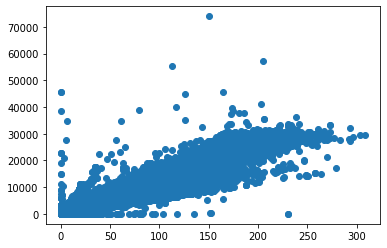

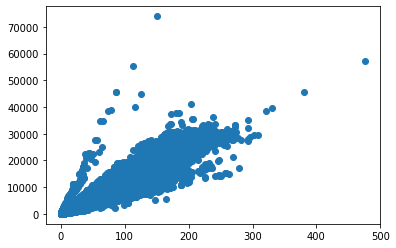

In [8]:
plt.scatter(df_3['VOLUME'], df_3['WEIGHT'])
plt.show()
plt.scatter(df_4['FIX_VOLUME'], df_4['FIX_WEIGHT'])
plt.show()

In [9]:
df_5 = df_4[(df_4['VOLUME'] > 250) & (df_4['WEIGHT'] > 55000)]
df_5['TAG'] = 1
df_4 = pd.merge(df_4, df_5[['DO_NO','TAG']].drop_duplicates(), on = 'DO_NO', how = 'left').fillna(0)

df_5 = df_4[(df_4['FIX_VOLUME'] > 250) & (df_4['FIX_WEIGHT'] > 55000)]
df_5['FIX_TAG'] = 1
df_4 = pd.merge(df_4, df_5[['DO_NO','FIX_TAG']].drop_duplicates(), on = 'DO_NO', how = 'left').fillna(0)

df_4.shape
df_4.head(1)

(636840, 23)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,UNIT_VOLUME_WEIGHT,FIX_WEIGHT,FIX_VOLUME,TAG,FIX_TAG
0,T1812314350909,2019-01-03 08:35:31,0.932393,大麻苴村马帮物流园（东方仓）,合肥美的电冰箱有限公司-内销,冰箱事业部,云南省,昆明市,官渡区,B,轻货,鄂DB5788,17.5米车,罗学忠,0.932393,76.0,1.0,39.146667,81.510693,76.0,0.932393,0.0,0.0


# 1. 数据聚合

### 1.1 数据聚合(df_5)

In [10]:
df_4.shape
df_4 = df_4.groupby(['DO_NO','PICK_UP_EARLIST', 'RECEIVE_VOLUME', 'FIX_ADDRESS', 'CUSTOMER', 'BU_NAME','RECEIVE_PROVINCE', 
                     'RECEIVE_CITY', 'RECEIVE_DISTRICT', 'BUSINESS_TYPE','FREIGHT_BASIS', 'LICENSE', 'EQUIPMENT', 
                     'DRIVER']).agg({'VOLUME':'sum', 'WEIGHT':'sum', 'QUANTITY':'sum', 'UNLOAD_TIME':'sum',
                     'FIX_WEIGHT':'sum','FIX_VOLUME':'sum'}).reset_index()
df_4.shape
df_4.head(1)

(636840, 23)

(556396, 20)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,5.28,368.5,55.0,5.562778,368.5,5.28


# 2 特征处理

### 2.1 卸货时间归整（df_6）

In [11]:
df_5 = df_4[(df_4['UNLOAD_TIME'] > 0.25) & (df_4['UNLOAD_TIME'] < 72)]
df_5['UNLOAD_TIME_INT'] = df_5['UNLOAD_TIME'].apply(lambda x: 2 if x <= 2
                                                       else 4 if x <= 4
                                                       else 6 if x <= 6
                                                       else 8 if x <= 8
                                                       else 12 if x <= 12
                                                       else 18 if x <= 18
                                                       else 32 if x<= 32
                                                       else 48)
df_5.shape
df_5.head(1)

(518185, 21)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,5.28,368.5,55.0,5.562778,368.5,5.28,6


### 2.2 季度，月

In [12]:
df_5['RECEIVE_MONTH'] = df_5['PICK_UP_EARLIST'].map(lambda x: x.month)
df_5['RECEIVE_SEASON'] = df_5['RECEIVE_MONTH'].map(lambda x: 1 if (x >= 3) & (x <= 5)
                                                    else 2 if( x >= 6) & (x <= 8)
                                                    else 3 if (x >= 9) & (x <= 11)
                                                    else 4 )
df_5.head(1)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,RECEIVE_MONTH,RECEIVE_SEASON
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,5.28,368.5,55.0,5.562778,368.5,5.28,6,9,3


### 2.3 车长提取

In [13]:
def find_re(x):
    if "40GP(海运)" in x:
        return 12
    elif "40HQ(海运)" in x:
        return 12
    elif "45HQ(海运)" in x:
        return 13
    elif re.search( r"\d+\.?\d*", x):
        return re.search( r"\d+\.?\d*", x).group()
    else:
        return 0

df_5["VEHICLE_LENGTH"] = df_5["EQUIPMENT"].apply(lambda x: find_re(str(x)))
df_5.head(1)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,RECEIVE_MONTH,RECEIVE_SEASON,VEHICLE_LENGTH
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,5.28,368.5,55.0,5.562778,368.5,5.28,6,9,3,17.5


### 2.4 统一客户名称 

In [14]:
customer = pd.read_excel('customer_name.xlsx')
df_5 = pd.merge(df_5, customer, how='left', on=['CUSTOMER'])
df_5.head(1)
df_5.shape

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,RECEIVE_MONTH,RECEIVE_SEASON,VEHICLE_LENGTH,company
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,5.28,368.5,55.0,5.562778,368.5,5.28,6,9,3,17.5,无锡小天鹅股份有限公司-内销


(518185, 25)

### 体积、重量和数据规整离散化

In [15]:
df_5['VOLUME_LEVEL'] = df_5['VOLUME'].apply(lambda x: 1 if x <= 1.5
                                            else 2 if x <= 3.5
                                            else 3 if x <= 7
                                            else 4 if x <= 13
                                            else 5 if x <= 25
                                            else 6 if x <= 50
                                            else 7)

df_5['WEIGHT_LEVEL'] = df_5['WEIGHT'].apply(lambda x: 1 if x <= 180
                                            else 2 if x <= 430
                                            else 3 if x <= 810
                                            else 4 if x <= 1450
                                            else 5 if x <= 2590
                                            else 6 if x <= 5680                                                       
                                            else 7)

In [16]:
df_5['QUANTITY_LEVEL'] = df_5['QUANTITY'].apply(lambda x: 1 if x <= 8
                                                else 2 if x <= 20                                                       
                                                else 3 if x <= 30                                                       
                                                else 4 if x <= 60
                                                else 5 if x <= 100
                                                else 6 if x <= 290
                                                else 7 )

### 卸货时间规整离散化为早上，上午，中午，下午，晚上，深夜 

In [17]:
df_5['PICK_UP_EARLIST_HOUR'] = df_5['PICK_UP_EARLIST'].map(lambda x: x.hour)

df_5['PERIOD_OF_TIME'] = df_5['PICK_UP_EARLIST_HOUR'].map(lambda x: 1 if 4 < x <= 8
                                                          else 2 if 8 < x <= 12
                                                          else 3 if 12 < x <= 14
                                                          else 4 if 14 < x <= 19
                                                          else 5 if 19 < x <= 24
                                                          else 6)

In [18]:
le1 = LabelEncoder()
le1.fit(df_5['FREIGHT_BASIS'])
df_5['FREIGHT_BASIS_LABEL'] = le1.transform(df_5['FREIGHT_BASIS'])
le1.classes_

LabelEncoder()

array(['轻货', '重货'], dtype=object)

In [19]:
le2 = LabelEncoder()
le2.fit(df_5['company'])
df_5['COMPANY_LABEL'] = le2.transform(df_5['company'])
le2.classes_

LabelEncoder()

array(['北京盛美卓越电器销售有限公司', '合肥美的洗衣机有限公司-内销', '合肥美的电冰箱有限公司-内销',
       '哈尔滨盛美卓越电器销售有限公司', '天津创世美的制冷产品销售有限公司', '天津市克来沃美的暖通设备销售有限公司',
       '天津盛美盈顺电器销售有限公司', '广东美的制冷设备有限公司-国内营销', '广东美的暖通设备有限公司-内销',
       '广东美的环境电器制造有限公司-两季国内公司', '广东美的集团芜湖制冷设备有限公司-芜湖营销', '无锡小天鹅股份有限公司-内销',
       '美智光电科技有限公司', '美的智慧家居科技有限公司', '芜湖美的厨卫电器制造有限公司-内销',
       '芜湖美的厨房电器制造有限公司-国内营销', '芜湖美的生活电器制造有限公司-生活内销', '重庆克来沃美的暖通设备销售有限公司',
       '重庆盛美盈顺电器销售有限公司', '重庆美的制冷设备有限公司-重庆营销', '重庆美的通用制冷设备有限公司-工厂'],
      dtype=object)

In [20]:
le3 = LabelEncoder()
le3.fit(df_5['LICENSE'])
df_5['LICENSE_LABEL'] = le3.transform(df_5['LICENSE'])
le3.classes_

LabelEncoder()

array(['予GD0559', '予HM3657', '云AG3612', ..., '黑MR4696', '黑MR4908',
       '黑MR5323'], dtype=object)

In [21]:
le4 = LabelEncoder()
le4.fit(df_5['FIX_ADDRESS'])
df_5['FIX_ADDRESS_LABEL'] = le4.transform(df_5['FIX_ADDRESS'])

LabelEncoder()

In [23]:
df_5['VEHICLE_LENGTH'] = df_5['VEHICLE_LENGTH'].astype('float64')

In [50]:
x = df_5.loc[:, ['FIX_ADDRESS_LABEL', 'COMPANY_LABEL', 'FREIGHT_BASIS_LABEL', 
                 'LICENSE_LABEL', 'PERIOD_OF_TIME',
                 'VOLUME_LEVEL', 'WEIGHT_LEVEL', 'QUANTITY_LEVEL', 
                 'RECEIVE_SEASON', 'VEHICLE_LENGTH']]

y = df_5.loc[:, ['UNLOAD_TIME_INT']]

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

## 随机森林

In [ ]:
vec = DictVectorizer()
x_train = vec.fit_transform(x_train.to_dict(orient="record"))
x_test = vec.transform(x_test.to_dict(orient="record"))

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(x_train, y_train)
print("随机森林预测准确率:", rfc.score(x_test, y_test))

# LightGBM

In [52]:
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

In [53]:
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [55]:
lgb_train = lgb.Dataset(x_train, y_train)

lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [56]:
params = {
    'num_leaves': 120,
    'metric': ['l1', 'l2'],
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 100,  
    'learning_rate': 0.06,  
    'feature_fraction': 0.8,  
    'bagging_fraction': 0.8,  
    'bagging_freq': 5,  
    'lambda_l1': 0.4,  
    'lambda_l2': 0.5,  
    'min_gain_to_split': 0.2,  
    'verbose': -1, 
}

In [57]:
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_test],
                feature_name=['f' + str(i + 1) for i in range(x_train.shape[-1])],
                categorical_feature=[21],
                evals_result=evals_result,
                verbose_eval=100)

[100]	training's l1: 8.38657	training's l2: 127.202	valid_1's l1: 8.44658	valid_1's l2: 128.829
[200]	training's l1: 8.06403	training's l2: 119.945	valid_1's l1: 8.17462	valid_1's l2: 123.033
[300]	training's l1: 7.87659	training's l2: 115.46	valid_1's l1: 8.03123	valid_1's l2: 119.819
[400]	training's l1: 7.73061	training's l2: 111.98	valid_1's l1: 7.92521	valid_1's l2: 117.436
[500]	training's l1: 7.60017	training's l2: 108.878	valid_1's l1: 7.8334	valid_1's l2: 115.394
[600]	training's l1: 7.49068	training's l2: 106.241	valid_1's l1: 7.75815	valid_1's l2: 113.692
[700]	training's l1: 7.39019	training's l2: 103.945	valid_1's l1: 7.68915	valid_1's l2: 112.248
[800]	training's l1: 7.30396	training's l2: 101.906	valid_1's l1: 7.63481	valid_1's l2: 111.059
[900]	training's l1: 7.22525	training's l2: 100.048	valid_1's l1: 7.58782	valid_1's l2: 110.041
[1000]	training's l1: 7.1523	training's l2: 98.3515	valid_1's l1: 7.54454	valid_1's l2: 109.089


### Plot metrics recorded during training 

In [58]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()

In [59]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=params['metric'])
else:
    render_metric(params['metric'][0])

interactive(children=(Dropdown(description='metric_name', options=('l1', 'l2'), value='l1'), Output()), _dom_c…

<function __main__.render_metric(metric_name)>

### Plot feature importances 

In [60]:
def render_plot_importance(importance_type, max_features=10, ignore_zero=True, precision=3):
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()

In [61]:
if INTERACTIVE:
    # create widget for interactive feature importance plot
    interact(render_plot_importance,
             importance_type=['split', 'gain'],
             max_features=(1, x_train.shape[-1]),
             precision=(0, 10))
else:
    render_plot_importance(importance_type='split')

interactive(children=(Dropdown(description='importance_type', options=('split', 'gain'), value='split'), IntSl…

<function __main__.render_plot_importance(importance_type, max_features=10, ignore_zero=True, precision=3)>

### Plot split value histogram 

In [62]:
def render_histogram(feature):
    ax = lgb.plot_split_value_histogram(gbm, 
                                        feature=feature,
                                        bins='auto',
                                        figsize=(10, 5))
    plt.show()

In [63]:
if INTERACTIVE:
    # create widget for interactive split value histogram
    interact(render_histogram,
             feature=gbm.feature_name())
else:
    render_histogram(feature='f26')

interactive(children=(Dropdown(description='feature', options=('f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',…

<function __main__.render_histogram(feature)>

### Plot trees 

In [64]:
def render_tree(tree_index, show_info, precision=3):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(gbm, 
                                   tree_index=tree_index,
                                   show_info=show_info, 
                                   precision=precision)

In [65]:
if INTERACTIVE:
    # create widget to switch between trees and control info in nodes
    interact(render_tree,
             tree_index=(0, gbm.num_trees() - 1),
             show_info=SelectMultiple(  # allow multiple values to be selected
                 options=['None',
                          'split_gain',
                          'internal_value',
                          'internal_count',
                          'internal_weight',
                          'leaf_count',
                          'leaf_weight',
                          'data_percentage'],
                 value=['None']),
             precision=(0, 10))
    tree = None
else:
    tree = render_tree(53, ['None'])
tree

interactive(children=(IntSlider(value=499, description='tree_index', max=999), SelectMultiple(description='sho…

<function __main__.render_tree(tree_index, show_info, precision=3)>

### LightGBM尝试其他参数训练

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

打印版本号

In [67]:
import sys
import scipy
import sklearn
print(sys.version)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('scipy:', scipy.__version__)
print('sklearn:', sklearn.__version__)
print('light gbm:', lgb.__version__)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
pandas: 1.0.4
numpy: 1.18.1
scipy: 1.4.1
sklearn: 0.22.1
light gbm: 2.3.2


In [68]:
lgb_train = lgb.Dataset(x_train, y_train)

lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train, free_raw_data=False)

In [99]:
num_train, num_feature = x_train.shape

In [116]:
params = {  
    'boosting_type': 'gbdt',  
    'objective': 'multiclass',  
    'num_class': 49,  
    'metric': 'multi_error',  
    'num_leaves': 120,  
    'min_data_in_leaf': 100,  
    'learning_rate': 0.06,  
    'feature_fraction': 0.8,  
    'bagging_fraction': 0.8,  
    'bagging_freq': 5,  
    'lambda_l1': 0.4,  
    'lambda_l2': 0.5,  
    'min_gain_to_split': 0.2,  
    'verbose': -1, 
}

print('Training...')

lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

clf = lgb.train(params,
                lgb_train,
                num_boost_round = 10000,
                valid_sets = [lgb_train,lgb_test],
                verbose_eval = 100,
                early_stopping_rounds =100)

print('Predicting...')
y_prob = clf.predict(x_test, num_iteration=clf.best_iteration)

y_pred = [list(x).index(max(x)) for x in y_prob]
print("AUC score: {:<8.5f}".format(accuracy_score(y_pred, y_test)))

Training...
Training until validation scores don't improve for 100 rounds
[100]	training's multi_error: 0.586565	valid_1's multi_error: 0.605187
[200]	training's multi_error: 0.543571	valid_1's multi_error: 0.572882
[300]	training's multi_error: 0.514809	valid_1's multi_error: 0.554395
[400]	training's multi_error: 0.494066	valid_1's multi_error: 0.540809
[500]	training's multi_error: 0.476777	valid_1's multi_error: 0.529462
[600]	training's multi_error: 0.463263	valid_1's multi_error: 0.521189
[700]	training's multi_error: 0.451461	valid_1's multi_error: 0.514544
[800]	training's multi_error: 0.441793	valid_1's multi_error: 0.508221
[900]	training's multi_error: 0.433368	valid_1's multi_error: 0.503602
[1000]	training's multi_error: 0.425764	valid_1's multi_error: 0.49854
[1100]	training's multi_error: 0.418982	valid_1's multi_error: 0.494661
[1200]	training's multi_error: 0.413016	valid_1's multi_error: 0.491097
[1300]	training's multi_error: 0.407657	valid_1's multi_error: 0.488196


### 网格搜索法进行调参 

In [ ]:
parameters = {
    'max_depth': [4,6,8],
    'num_leaves': [20,30,40],
}

gbm = lgb.LGBMClassifier(
                         objective = 'multiclass',
                         is_unbalance = True,
                         metric = 'multi_logloss',
                         max_depth = 6,
                         num_leaves = 40,
                         learning_rate = 0.1,
                         feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         bagging_fraction = 1,
                         bagging_freq = 2,
                         reg_alpha = 0.001,
                         reg_lambda = 8,
                         cat_smooth = 0,
                         num_iterations = 200,)

gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=3, n_jobs=-1)
gsearch.fit(x_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

# 以下不用看！！！！！

# 1. 商品分类
    输入： fixed     
    输出： df_cluster

In [ ]:
dispatch_3 = dispatch_2[['ITEM_NAMES', 'UNIT_WEIGHT', 'UNIT_VOLUME']].drop_duplicates()
X0 = np.array(dispatch_3['UNIT_WEIGHT'])
X1 = np.array(dispatch_3['UNIT_VOLUME'])
plt.figure()
# plt.axis([-1, 9, -1, 9])
plt.grid(True)
plt.plot(X0, X1, 'k.')

# dispatch_4[dispatch_4['WEIGHT']>6000]

In [ ]:
#标准化
def norm(x, x_max, x_min):
    return  (x - x_min) / (x_max - x_min)
def std(x, mu, sigma):
    return  (x - mu) / sigma
def norm_df(df):
    v_min = np.min(df['UNIT_VOLUME'])
    v_max = np.max(df['UNIT_VOLUME'])
    w_min = np.min(df['UNIT_WEIGHT'])
    w_max = np.max(df['UNIT_WEIGHT'])
    df['VOLUME_NORM'] = df.apply(lambda x: norm(x.UNIT_VOLUME, v_max, v_min), axis = 1)
    df['WEIGHT_NORM'] = df.apply(lambda x: norm(x.UNIT_WEIGHT, w_max, w_min), axis = 1)
    return df

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
items = dispatch_2[(dispatch_2['UNIT_VOLUME'] <= 30) & (dispatch_2['UNIT_WEIGHT'] <= 2000)]
items = items[['ITEM_NAMES', 'UNIT_VOLUME', 'UNIT_WEIGHT', 'FREIGHT_BASIS']].drop_duplicates()

items = norm_df(items)
X1 = np.array(items['VOLUME_NORM'])
X2 = np.array(items['WEIGHT_NORM'])
X = np.array(list(zip(X1, X2))).reshape(len(X1), 2)
k_model = KMeans(n_clusters=3).fit(X)
y_pred = k_model.labels_
items['CLUSTER'] = y_pred

items_ex = dispatch_2[(dispatch_2['UNIT_VOLUME'] > 30) | (dispatch_2['UNIT_WEIGHT'] >= 2000)][['ITEM_NAMES', 'UNIT_VOLUME', 'UNIT_WEIGHT']].drop_duplicates()
items_ex['CLUSTER'] = 3
items = pd.concat([items_ex, items[['ITEM_NAMES', 'UNIT_VOLUME', 'UNIT_WEIGHT','CLUSTER' ]]])
items.head()

In [ ]:
items['CLUSTER'].value_counts()

In [ ]:
df_1 = pd.merge(dispatch_2, items, on = ['ITEM_NAMES', 'UNIT_VOLUME', 'UNIT_WEIGHT'], how = 'left').fillna('NA')
df_cluster = pd.DataFrame(df_1.groupby(['DISPATCH_NO','RECEIVER_LNG', 'RECEIVER_LAT','CLUSTER']
                                           )['QTY'].sum()).rename(columns = {'QTY':'count'}).reset_index()
df_cluster = pd.pivot_table(df_cluster, index = ['DISPATCH_NO','RECEIVER_LNG', 'RECEIVER_LAT'
                                      ] , columns = ['CLUSTER'], values = ['count']).fillna(0).reset_index()
cols =['DISPATCH_NO','RECEIVER_LNG', 'RECEIVER_LAT']+ [str(i) for i in list(df_cluster.columns.levels[1])[:-1]]
df_cluster.columns = cols
df_cluster = pd.merge(dispatch_2, df_cluster, on = ['DISPATCH_NO','RECEIVER_LNG', 'RECEIVER_LAT' ], how = 'left').fillna('NA')
df_cluster = df_cluster[['DISPATCH_NO', 'RECEIVER_PROV', 'RECEIVER_CITY', 'RECEIVER_DIST', 'RECEIVER_LNG', 
                         'RECEIVER_LAT', 'BUSINESS_MODE', 'DRIVER', 'VEHICLE_CARD', 'TOTAL_VOLUME', 
                         'TOTAL_WEIGHT', 'TOTAL_QTY', 'UNIT_VOLUME', 'UNIT_WEIGHT', 'QTY', 
                         '0', '1', '2', '3','VEHICLE_LENGTH']].drop_duplicates()
df_cluster.head()

# 5. Level划分

In [ ]:
df_1 = df[df['unload_t']<=360]
df_1.shape

In [ ]:
df_1['unloade_t_level'] = df_1['unload_t'].apply(lambda x: 1 if x<=20
                                                              else 2 if x<=40
                                                              else 3 if x<=60
                                                              else 4)
df_1['volume_level'] = df_1['total_volume'].apply(lambda x: 1 if x<=1
                                               else 2 if x<=2.5
                                               else 3 if x<=3.5
                                               else 4 if x<=5.5
                                               else 5 if x<=12     
                                              else 6)
df_1['weight_level'] = df_1['total_weight'].apply(lambda x: 1 if x<=50
                                               else 2 if x<=150
                                               else 3 if x<=250
                                               else 4 if x<=400
                                               else 5 if x<=800
                                              else 6)

df_1['items_volume_level'] = df_1['items_volume'].apply(lambda x: 1 if x<=1
                                               else 2 if x<=2.5
                                               else 3 if x<=3.5
                                               else 4 if x<=5.5
                                               else 5 if x<=12     
                                              else 6)
df_1['items_weight_level'] = df_1['items_weight'].apply(lambda x: 1 if x<=50
                                               else 2 if x<=150
                                               else 3 if x<=250
                                               else 4 if x<=400
                                               else 5 if x<=800
                                              else 6)

# 时间预测

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
# 集成分类库和投票方法库
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
# StratifiedKFold：适用于有标签数据集的交叉检验数据集划分方法。cross_val_score：通过交叉检验方法做模型效果评估。导入交叉检验算法
from sklearn.model_selection import StratifiedKFold, cross_val_score

# x = np.array(auto_42[['volume_level','weight_level']])
# y = np.array(auto_42[['unloade_t_level']])
# df_1['address'] = df_1['receiver_lng'].astype('str') + '-' + df_1['receiver_lat'].astype('str')

# x = df_1[['receiver_city',  'items_volume_level', 'items_weight_level', 
#           '0', '1', '2', '3', '4', '5', '6', '7', '仓库', '住宅', '公司', '其他', '商业', '学校医院', '工地','driver']]
x = df_1[['receiver_city',  'items_volume_level', 'items_weight_level', 
          '0', '1', '2', '3', '4', '5', '6', '7', '仓库', '住宅', '公司', '其他', '商业', '学校医院', '工地','driver']]
y = df_1[['unloade_t_level']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
vec = DictVectorizer()
x_train = vec.fit_transform(x_train.to_dict(orient="record"))
x_test = vec.transform(x_test.to_dict(orient="record"))
Starting training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
print("随机森林预测准确率:", rfc.score(x_test, y_test))

xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
print("XGBoost预测准确率:", xgbc.score(x_test, y_test))

# 交叉检验
model_rf = RandomForestClassifier(max_features=0.8, random_state=0)  # 随机森林分类模型对象
model_gdbc = GradientBoostingClassifier(max_features=0.8, random_state=0)  # GradientBoosting分类模型对象
estimators = [('randomforest', model_rf), ('gradientboosting', model_gdbc)]  # 建立组合评估器列表
# voting：投放方法设置为soft，意味着使用每个分类器的概率做投票统计，最终按投票概率选出；还可以设置为hard，意味着通过每个分类器的label按得票最多的label做预测输出。
model_vot = VotingClassifier(estimators=estimators, voting='soft', weights=[0.9, 1.2], n_jobs=-1)  # 建立组合评估模型
cv = StratifiedKFold(7, shuffle=True, random_state=2)  # 设置交叉检验方法
cv_score = cross_val_score(model_gdbc, x_train, y_train, cv=cv)  # 交叉检验
print('{:*^60}'.format('Cross val scores:'), '\n', cv_score)  # 打印每次交叉检验得分
print('Mean scores is: %.2f' % cv_score.mean())  # 打印平均交叉检验得分

In [ ]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

clf = TPOTClassifier(population_size=10, offspring_size=100, scoring='accuracy',
cv=3, n_jobs=-1, max_time_mins=5, max_eval_time_mins=2, random_state=0, 
config_dict=None, periodic_checkpoint_folder=None, verbosity=1)

clf.fit(x_train, y_train)
clf.score(x_test, y_test)

In [ ]:
plt.hist(x = df_1.unloade_t_level, # 指定绘图数据
         bins = 20, # 指定直方图中条块的个数
        color = 'steelblue', # 指定直方图的填充色
        edgecolor = 'black' # 指定直方图的边框色
        )
plt.xlabel('卸载时间')
plt.ylabel('频数')
plt.show()

In [ ]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

X, y 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

clf = TPOTClassifier(population_size=10, offspring_size=100, scoring='accuracy',
cv=3, n_jobs=-1, max_time_mins=5, max_eval_time_mins=2, random_state=0, 
config_dict=None, periodic_checkpoint_folder=None, verbosity=1)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
# df_1[df_1['dispatch_no'] == 'CP20200112004252']
df_cluster[df_cluster['dispatch_no'] == 'CP20200112004252']

In [ ]:
df_1['town'] = df_1['receiver_city'].astype('str') + '-' + df_1['receiver_dist'].astype('str'
                                        ) + '-' + df_1['receiver_town'].astype('str')
x = df_1[['receiver_city', 'vehicle_length', 'items_volume_level', 'items_weight_level', 
            '0', '1', '2', '3', '4', '5', '6']]
y = df_1[['unloade_t_level']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
vec = DictVectorizer()
x_train = vec.fit_transform(x_train.to_dict(orient="record"))
x_test = vec.transform(x_test.to_dict(orient="record"))

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
print("随机森林预测准确率:", rfc.score(x_test, y_test))

xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
print("XGBoost预测准确率:", xgbc.score(x_test, y_test))

In [ ]:
df_1['address'] = df_1['receiver_lng'].astype('str') + '-' + df_1['receiver_lat'].astype('str')
x = df_1[['receiver_city', 'vehicle_length', 'items_volume_level', 'address',
          'items_weight_level', '0', '1', '2', '3', '4', '5', '6', 'vehicle_card']]
y = df_1[['unloade_t_level']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
vec = DictVectorizer()
x_train = vec.fit_transform(x_train.to_dict(orient="record"))
x_test = vec.transform(x_test.to_dict(orient="record"))

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
print("随机森林预测准确率:", rfc.score(x_test, y_test))

xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
print("XGBoost预测准确率:", xgbc.score(x_test, y_test))

In [ ]:
df_1['address'] = df_1['receiver_lng'].astype('str') + '-' + df_1['receiver_lat'].astype('str')
x = df_1[['receiver_city', 'vehicle_length', 'address','items_volume_level', 'heavy', 'heavy_light', 'light',
          'items_weight_level',  '0', '1', '2', '3', '4', '5']]
y = df_1[['unloade_t_level']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
vec = DictVectorizer()
x_train = vec.fit_transform(x_train.to_dict(orient="record"))
x_test = vec.transform(x_test.to_dict(orient="record"))

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
print("随机森林预测准确率:", rfc.score(x_test, y_test))

xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
print("XGBoost预测准确率:", xgbc.score(x_test, y_test))

In [ ]:
df_1.shape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corrmat = df_1.corr().abs()
sns.heatmap(corrmat)
plt.show()
print(corrmat)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import StratifiedKFold #交叉验证

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=4, min_samples_leaf=2),
                         algorithm="SAMME.R", n_estimators=100, learning_rate=0.5)
model_to_set = OneVsRestClassifier(bdt)

model_to_set.fit(x_train, y_train)
print ("Score:", model_to_set.score(x_test, y_test))